# Vorbereitung (Datenanalyse- und visualisierung von Tankstellen und dessen Kraftstoffpreisdaten über den Zeitraum 2014-heute in Deutschland)

## Einleitung

Unser Datensatz mit dem Titel **"Historische Kraftstoffpreisdaten in Deutschland"** lässt sich unter https://dev.azure.com/tankerkoenig/_git/tankerkoenig-data finden und ist in **Stations** und **Prices** aufgeteilt. Stations listet jede aktive Tankstelle in Deutschland auf, wohingegen in Prices alle Preisänderungen von Diesel, Super 95 (E5) und Super E10 von Juni 2014 bis jetzt enthalten sind. Anfänglich stellten wir uns die Frage, wie es möglich sei die Fülle dieser Daten so akkurat zu erfassen. Unsere Hintergrundrecherche ergab, dass jede öffentliche Tankstelle seit dem 31. August 2013 Preisänderungen von Super 95, Super E10 und Diesel in Echtzeit an die sog. **Markttransparenzstelle für Kraftstoffe** des Bundeskartellamtes melden muss. Auf Grund der Tatsache, dass das Bundeskartellamt die gewonnenen Daten ausschließlich lizensierten Spritpreis-Informationsdiensten über eine API-Schnittstelle zur Verfügung stellt, beziehen wir unsere Daten aus dem Archiv des "Tankerkönigs", welches mit dem Befehl

heruntergeladen werden kann. Die dort archivierten Daten werden seit Juni 2014 tagesweise archiviert und jeweils am Folgetag als Datenbank-Dump in Form einer CSV-Datei bereitgestellt. Auf diese Weise umfasst das Archiv mehr als 3.000 CSV-Dateien mit durchschnittlich ca. 350.000 Einträgen, so dass man auf eine Gesamtanzahl von über 1 Milliarde Datenpunkten kommt. Welche Problematiken diese riesige Datenmenge auslöste und wie wir diese Probleme letztendlich lösen konnten, erklären wir im weiteren Verlauf.

Beschäftigen wir uns nun aber zuerst mit dem eigentlichen Ablauf dieser Datenvisualisierung. Anfänglich werden wir uns mit dem Datensatz vertraut machen, die Bedeutungen der verschiedenen Spalten klären und etwas Data Cleaning betreiben. Daraufhin werden wir ein Verständnis über die größten Tankstellenmarken und deren Marktanteile aufbauen und uns anschließend die geografischen Unterschiede anzeigen lassen. Hier werden wir speziell auf die, nach wie vor bestehenden, Unterschiede zwischen "Ost" und "West" eingehen. Abschließend skizzieren wir die historische Preisentwicklung und werden die aktuellen und herausstechende Preisänderungen seit Beginn des Krieges in der Ukraine hervorheben.

## Library Imports

Damit wir unsere Daten fachgerecht bereinigen, präparieren und schlussendlich visualisieren können, importieren wir folgende, in der Datenanalyse- und visualisierung weit verbreitete, Biblotheken. Diese werden von uns zur Visualisierung und Aufbereitung der Daten benutzt und können teilweise als Pendant zu der in R häufig verwendeten Biblothek *ggplot2* angesehen werden:

1. **pandas**: Eine Python-Bibliothek, die speziell für die Datenmanipulation und -analyse entwickelt wurde. Sie ermöglicht es, Datenframes zu erstellen und bietet eine Vielzahl nützlicher Funktionen zur Datenbereinigung und -verarbeitung.

2. **matplotlib.pyplot**: Eine der bekanntesten Python-Bibliotheken zur Erstellung von Diagrammen und Visualisierungen. Mit pyplot können Sie eine Vielzahl von Diagrammtypen erstellen, darunter Balkendiagramme, Liniendiagramme und Histogramme.

3. **seaborn**: Eine Python-Bibliothek zur Erstellung ansprechender Diagramme und Visualisierungen. Sie baut auf matplotlib auf und bietet einfachere Methoden zur Erstellung von Diagrammen.

4. **os**: Eine Python-Bibliothek, die Methoden zum Arbeiten mit dem Betriebssystem bereitstellt, wie zum Beispiel zum Navigieren im Dateisystem oder zum Erstellen von Verzeichnissen.

5. **PolygonPatch**: Die Klasse PolygonPatch wird in der Regel in Verbindung mit anderen Bibliotheken wie matplotlib oder geopandas verwendet, um visuelle Darstellungen von Polygonen in Diagrammen oder Karten zu erstellen. Sie bietet eine bequeme Möglichkeit, Polygon-Patches mit spezifischen Attributen wie Farben, Kantenbreiten und Transparenz hinzuzufügen, um die visuelle Präsentation von räumlichen Daten zu verbessern.

6. **shapefile**: Eine Python-Bibliothek zur Arbeit mit Shapefiles, einem geografischen Vektordatendateiformat. Sie ermöglicht das Lesen, Schreiben und Manipulieren von Shapefiles für die Analyse und Visualisierung von geografischen Daten in Python.
   
7. **datetime**: Ein Modul in Python, das Funktionen und Klassen zur Arbeit mit Datum und Zeit bereitstellt. Es ermöglicht das Erstellen, Manipulieren und Formatieren von Datum- und Zeitobjekten. Mit dem datetime-Modul können Berechnungen und Vergleiche zwischen verschiedenen Zeitpunkten durchgeführt werden.

8. **dateutil.relativedelta**: Eine Funktion aus dem dateutil-Paket, das auf das datetime-Modul aufbaut. Die dateutil.relativedelta ermöglicht es, Zeitdifferenzen zwischen zwei Zeitpunkten in einem flexiblen und intuitiven Format zu berechnen. Es erlaubt die Angabe von relativen Änderungen wie "2 Monate vorwärts" oder "1 Jahr und 3 Tage rückwärts" und ermöglicht es, solche Zeitdifferenzen präzise zu berechnen und auf Datum- oder Zeitobjekte anzuwenden.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from   descartes import PolygonPatch
import shapefile
from datetime import datetime
from dateutil.relativedelta import relativedelta

## Data Imports

### Preprocessing

Wie so oft geht das ganze nicht ohne kleine aber sehr hilfreichen Tricks, in unserem Fall **Preprocessing**. Preprocessing bezeichnet die Vorverarbeitung von Rohdaten, um sie für die weitere Verarbeitung und Analyse vorzubereiten. Da die Prices-CSV-Dateien insgesamt eine Größe von über 50 GB haben und jegliche pro Tankstelle anfallende Spritpreisaktualisierungen in Deutschland seit 2014 enthalten, mussten wir die Größe reduzieren, um sie effizient verarbeiten zu können. Wir entschieden uns, die Daten nach station_id, Jahr und Monat zu gruppieren und die Durchschnittspreise für die Kraftstoffarten Diesel, Super 95 (E5) und Super E10 einmal pro Monat anstelle pro Minute zu berechnen und in neuen CSV-Dateien zu speichern. Dadurch konnten wir die Gesamtgröße von über 50 GB auf etwa 90 MB reduzieren. Die Auslagerung der Aggregation in eine separate Funktion dient der besseren Performance und besseren Lesbarkeit des Codes. Die detaillierte Beschreibung des Codes würde hier aber zu weit gehen, weshalb unser Code hierzu bei Interesse im Anhang zu finden ist. 

### DataFrames

Nach dem uns nun die aggregierten Daten vorliegen werden die entstandenen CSV-Dateien anhand des folgenden Codes eingelesen und in verschiedenen DataFrames gespeichert. Dies ist ein wichtiger Schritt, um eine breitere Datenbasis für zukünftige Analysen zu erhalten und sicherzustellen, dass die Daten korrekt interpretiert werden können. Zusätzlich werden auch fehlerhafte CSV-Dateien gefiltert und übersprungen, um mögliche Fehler in den Daten zu vermeiden.

Um eine einheitliche und korrekte Verarbeitung der Daten zu gewährleisten, wird die Datum-Spalte in das Datumformat umgewandelt. Durch das Einlesen und Zusammenführen der Daten aus verschiedenen CSV-Dateien in verschiedenen DataFrames wird eine bessere Analyse und Verarbeitung der Daten ermöglicht. Dies ist insbesondere von Vorteil, da die CSV-Dateien unterschiedliche Themenbereiche abdecken.

Der Code durchläuft mittels Schleife den Ordner, in dem die CSV-Dateien gespeichert sind, liest diese ein und speichert die darin enthaltenen Daten in verschiedenen DataFrames. Für den Monat März 2023 wird ein leeres DataFrame "march_2023" initialisiert, um die Daten zu speichern. Für den Ordner "timeseries" wird ebenfalls ein leeres DataFrame "timeseries" erstellt, um die Daten aus den CSV-Dateien zu speichern.

Nach dem Einlesen und Verarbeiten der CSV-Dateien werden die Informationen zu den verschiedenen Stationen, von denen die Daten stammen, in das DataFrame "stations" geladen.

In [2]:
# path + df to store
folder_path = '04'
april_2023 = pd.DataFrame()

# looping through folder + append + date fixing
for filename in os.listdir(folder_path):
    if filename.endswith('.csv'):
        file_path = os.path.join(folder_path, filename)
        try:
            temp_df = pd.read_csv(file_path)
            temp_df['date'] = pd.to_datetime(temp_df['date'], format='%Y-%m-%d').dt.date
            april_2023 = april_2023.append(temp_df)
        except Exception:
            # if something is wrong in the csv file
            print(f"Error converting date column in {filename}. Skipping file...")

# path + df to store
folder_path2 = 'timeseries'
timeseries = pd.DataFrame()

# looping through folder + append + date fixing
for filename in os.listdir(folder_path2):
    if filename.endswith('.csv'):
        file_path = os.path.join(folder_path2, filename)
        temp_df = pd.read_csv(file_path)
        try:
            timeseries = timeseries.append(temp_df)
        except Exception:
            # if something is wrong in the csv file
            print(f"Error converting date column in {filename}. Skipping file...")

# read stations
stations = pd.read_csv('stations.csv')

C:\Users\PhilippMeyer\AppData\Local\Temp\ipykernel_24932\3268921350.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  april_2023 = april_2023.append(temp_df)
C:\Users\PhilippMeyer\AppData\Local\Temp\ipykernel_24932\3268921350.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  april_2023 = april_2023.append(temp_df)
C:\Users\PhilippMeyer\AppData\Local\Temp\ipykernel_24932\3268921350.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  april_2023 = april_2023.append(temp_df)
C:\Users\PhilippMeyer\AppData\Local\Temp\ipykernel_24932\3268921350.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  april_2023 = april_2023.append(temp_df)


## Data Cleaning

In der Zeitreihenanalyse ist die Datenbereinigung ein wichtiger Schritt, um sicherzustellen, dass die verwendeten Daten korrekt und zuverlässig sind. Wir führen verschiedene Schritte durch, um sicherzustellen, dass die Daten sauber sind. Zunächst erstellen wir eine neue Spalte mit Datumsinformationen, um die Handhabung der zeitabhängigen Daten zu erleichtern. Dann filtern wir nur die für unsere Analyse relevanten Spalten in den Datenframes und entfernen Zeilen mit fehlenden oder unzuverlässigen Daten. Dadurch stellen wir sicher, dass unsere Analyse auf vertrauenswürdigen Daten basiert und aussagekräftige Ergebnisse liefert.

In [3]:
#correcting date
timeseries['date'] = timeseries['year'].astype(str) + ' ' + timeseries['month'].apply(lambda x: '{:02}'.format(x))
timeseries['date'] = pd.to_datetime(timeseries['date'], format='%Y %m')

### filter for relevant variables
stations = stations[['uuid', 'city', 'brand', 'post_code', 'latitude', 'longitude']]
timeseries = timeseries[['station_uuid', 'date', 'diesel', 'e5', 'e10']]
april_2023 = april_2023[['station_uuid', 'date', 'diesel', 'e5', 'e10']]

### renaming uuid
stations = stations.rename( columns= {'uuid' : 'station_uuid'})

# drop NaN values
stations.dropna(inplace=True)
timeseries.dropna(inplace=True)
april_2023.dropna(inplace=True)

# drop rows where diesel or e10 or e5are 0
timeseries = timeseries.loc[(timeseries.diesel != 0) & (timeseries.e10 != 0) & (timeseries.e5 != 0)]
march_2023 = april_2023.loc[(april_2023.diesel != 0) & (april_2023.e10 != 0) & (april_2023.e5 != 0)]


## Variablenbeschreibung

Die Variable "station_uuid" steht für "Universally Unique Identifier" und ist eine 128-Bit-Zahl, die zur Identifizierung von Objekten in Computersystemen verwendet wird und wurde von der Open Software Foundation (OSF) als Teil des Distributed Computing Environment (DCE) standardisiert und ist jetzt in RFC 4122 geregelt. 
"city" ist der Name der Stadt, in der die Tankstelle steht. In "brand" ist die Marke der Tankstelle  genannt, wie z.B. "ARAL" oder "Shell". "post_code" ist die fünfstellige Postleitzahl des Ortes, in der die Tankstelle steht. "latitude" ist der geographische Breitengrad in Grad, auf der sich die Tankstelle befindet. "longitude" ist der geographische Längengrad in Grad, auf der sich die Tankstelle befindet, welcher mit "laditude" die Koordinaten der Tankstelle bildet.

Die Variablen "diesel", "e10" und "e5" des "prices"-Datensatzes beinhalten den Preis des jeweiligen Kraftstoffes auf die dritte Nachkommastelle genau in Euro, z.B. "1.689" Euro. An welchem Tag die Daten erfasst wurden, wird in der Variable "date" dokumentiert, wobei das Datum die Formatierung YYYY-MM-DD hat. Die Preise einer Zeile wurden gleichzeitig erfasst. Auch in Stations ist die die Spalte "uuid" enthalten, so dass Tankstellendaten und Preise zusammengeführt werden können.

# Plots

## Verteilung der deutschen Marktteilnehmer in der Tankstellenbranche  

Mit dem folgenden Code stellen wir einen Überblick über die in Deutschland vertretenen Tankstellenmarken und deren Marktanteile dar. Hierbei beschränken wir uns aus Gründen der besseren Übersichtlichkeit auf die Top 5. Das Balkendiagramm ermöglicht es uns, schnell die Anzahl der Tankstellen für jede Marke zu vergleichen und festzustellen, welche Marken den größten Marktanteil haben. Die Hinzufügung der Anzahl-Werte innerhalb jedes Balkens liefert detailliertere Informationen und ermöglicht es uns, die genaue Anzahl der Tankstellen für jede Marke zu sehen. Der Donut-Plot auf der rechten Seite gibt Aufschluss auf die prozentualen Marktanteile der Top 5 und ergänzt den Vergleich mit den restlichen Tankstellen.

C:\Users\PhilippMeyer\AppData\Local\Temp\ipykernel_24932\873204287.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  top_brands = top_brands.append(rest_brands)


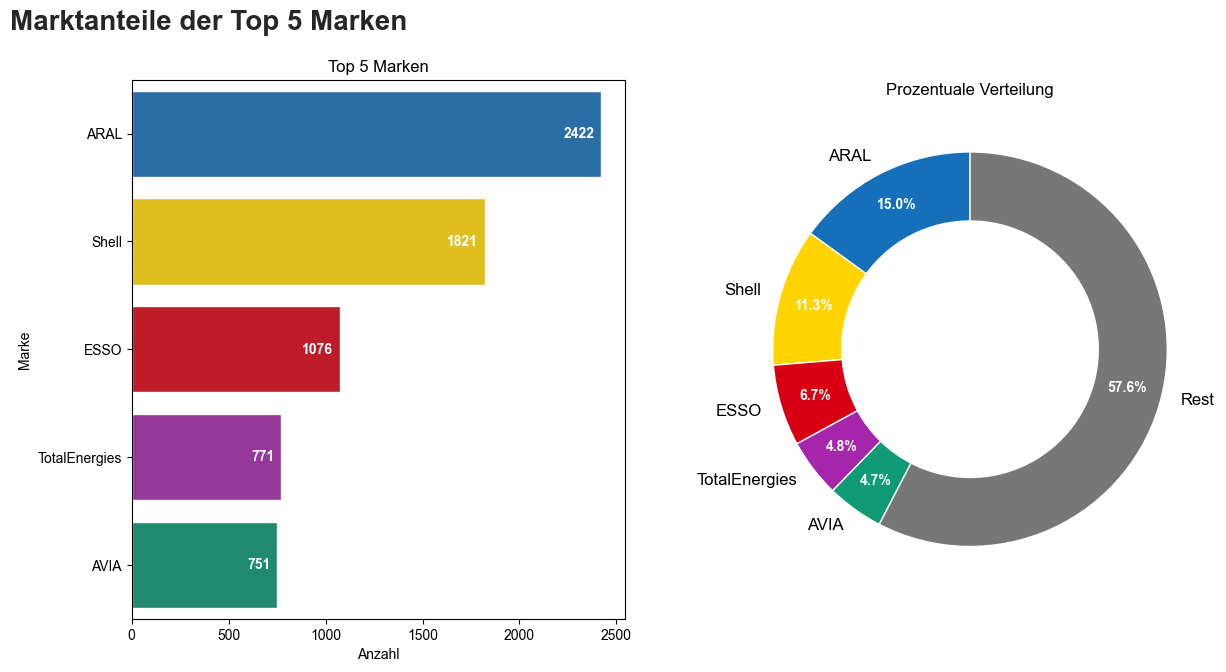

In [4]:
# for same size etc
title_fontsize = 20
width = 14

# Load the dataset
brand_stations = stations

# Filter for top 5 brands
top_brands = brand_stations.groupby('brand')['brand'].count().reset_index(name='count').nlargest(5, 'count')
top_brands_list = top_brands['brand'].unique()
rest_brands = brand_stations.loc[~brand_stations['brand'].isin(top_brands_list)].agg({'brand': 'count'}).reset_index()
rest_brands = rest_brands.rename(columns={'index': 'brand', 0 : 'count'})
rest_brands['brand'] = rest_brands['brand'].replace('brand', 'Rest')

# colors for brands
custom_palette = ['#1670B9', '#FFD400', '#DA0013', '#A526AB', '#109A76', '#777777'] 

# creating figure
fig, ax = plt.subplots(1,2, figsize=(width,7))
sns.set_style('whitegrid')
title = fig.suptitle('Marktanteile der Top 5 Marken', fontsize= title_fontsize, fontweight= 'bold')
title.set_x(0.18)

# barplot
sns.barplot(data=top_brands, y='brand', x='count', ax= ax[0], palette= custom_palette)

# Add count inside each bar
for i, v in enumerate(top_brands['count']):
    ax[0].annotate(str(v), xy=(v, i), va='center', ha='right', fontsize=10, color='white', 
                xytext=(-5, 0), textcoords='offset points', fontweight= 'bold')

# Set plot attributes
ax[0].set(title='Top 5 Marken', xlabel='Anzahl', ylabel='Marke')

# add rest
top_brands = top_brands.append(rest_brands)

# Create a donut 
sizes = top_brands['count']
labels = top_brands['brand']
colors = custom_palette[:len(sizes)]

# white circle
wedgeprops = {"edgecolor": "w", 'linewidth': 1, 'width': 0.35}
# set pie
_, lab, pct = ax[1].pie(sizes, labels=labels, colors=colors, startangle=90, 
                    wedgeprops=wedgeprops, autopct='%1.1f%%', pctdistance=0.82)

# set the color of the labels to red
plt.setp(lab, color='black', fontsize= 12)
plt.setp(pct, color='white', fontsize= 10, fontweight= 'bold')

# Set plot attributes
ax[1].set(title='Prozentuale Verteilung', 
       xlabel='', ylabel='')

# Show the plot
plt.show()

## Geografische Visualisierung der Top 5 Tankstellenmarken in Deutschland

Nachdem wir nun wissen, welche Tankstellenmarken in Deutschland am stärksten vertreten sind, ist die geografische Verteilung dieser von Interesse. Die folgenden Plots stellen die Tankstellen der größten 5 Marken sowohl als Gesamtübersicht, als auch aufgeschlüsselt pro Marke, dar.

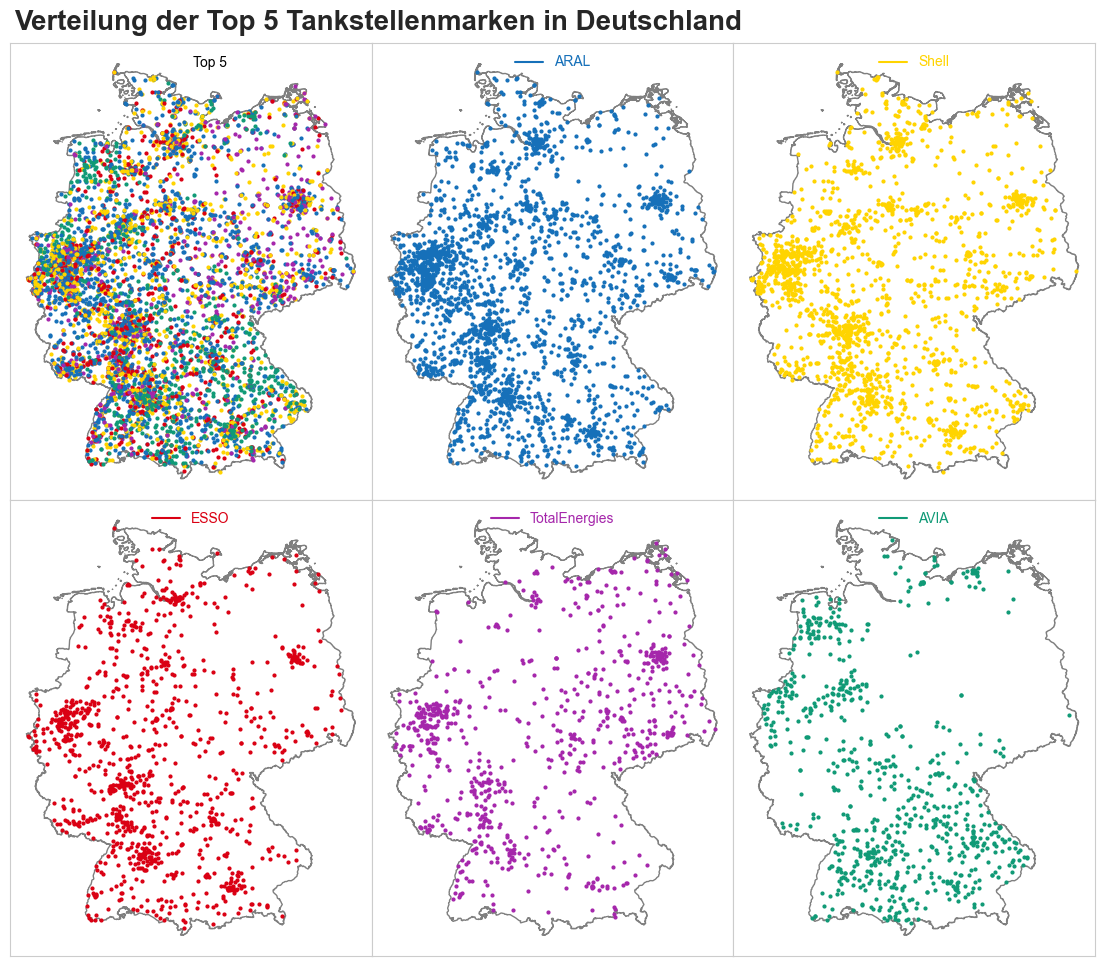

In [5]:
# Select only the top 5 brands and don't sort by count
top_brands = stations['brand'].value_counts(sort=False).nlargest(5).index.tolist()
df_map = stations[stations['brand'].isin(top_brands)]

fig, axes = plt.subplots(2,3, figsize=(width,11))
sns.set_style('whitegrid')

# add a title to the map
title = fig.suptitle('Verteilung der Top 5 Tankstellenmarken in Deutschland', fontsize= title_fontsize, fontweight= 'bold')

shapefile_data = shapefile.Reader('DEU_adm0.shp')

# create legend labels and colors
stations_loop = ['Top 5'] + top_brands
legend_labels = top_brands
legend_colors = [custom_palette[top_brands.index(brand)] for brand in top_brands]

# adding dots based on latitudes and longitudes
for ax, string in zip(axes.flatten(),stations_loop):
    # drawn shape file
    poly= shapefile_data.shape()
    ax.add_patch(PolygonPatch(poly, fc='#ffffff', ec='#000000', alpha=0.5, zorder=2 ))

    # differ betwenn all and seperate
    if string == 'Top 5':   
        # print dots
        for t, row in df_map.iterrows():
            ax.plot(row['longitude'], row['latitude'], marker='o', markersize=2, 
                    color=custom_palette[top_brands.index(row['brand'])])
            
        # add legend without color
        handles_all = [plt.Line2D([], [], linestyle='', label=string, marker= 'None')]
        ax.legend(handles=handles_all, loc='upper center', ncol=len(legend_labels), labelcolor='black', frameon=False)

    else:
        # print dots
        for t, row in df_map[df_map.brand == string].iterrows():
            ax.plot(row['longitude'], row['latitude'], marker='o', markersize=2, 
                    color=custom_palette[top_brands.index(row['brand'])])
        
        # add legend to the map
        handles = [plt.Line2D([], [], linestyle='-', label=string, color=custom_palette[top_brands.index(string)])]
        ax.legend(handles=handles, loc='upper center', ncol=len(legend_labels), labelcolor=custom_palette[top_brands.index(string)], frameon=False)
            
    # Remove stuff around
    ax.grid(False)
    ax.set_xticks([])
    ax.set_yticks([])

# Adjust spacing
fig.subplots_adjust(top=0.94, hspace=0 , wspace=0)
title.set_y(0.97)
title.set_x(0.388)

# plotting
plt.show()

Deutschland verfügt über ein großflächiges Tankstellennetz, das sich jedoch ungleichmäßig auf verschiedene Regionen verteilt. Insbesondere im Ruhrgebiet, Berlin und Frankfurt sowie weiteren dicht besiedelten Gebieten gibt es zahlreiche Tankstellen. Im Vergleich dazu ist die Anzahl der Tankstellen in weniger besiedelten Regionen, wie Mecklenburg-Vorpommern vergleichsweise gering. Es gibt auch Unterschiede zwischen Ost und West, da im Osten Deutschlands weniger Tankstellen vorhanden sind und nicht alle Top-5-Tankstellenmarken, wie zum Beispiel AVIA, dort vertreten sind. Die Geomap zeigt somit die Verteilung der Top-5-Tankstellenmarken in Deutschland auf und hebt die heutzutage in Teilen immer noch bestehenden infrastrukturellen Unterschiede zwischen Ost und West hervor.

## Aktueller Spritpreisvergleich der Marken

Wir hatten die Vermutung, dass Kraftstoff-Preise in den neuen Länder geringer sein könnten, als in den alten Ländern wie es öfter der Falls ist z.B. bei Grundstücken. Um dies zu überprüfen, erstellen wir ein Balken-Diagramm mit den durchschnittlichen Preisen der Kraftstoffe je Bundesland. Dabei bezieht sich der Durchschnitt auf die Preise im März des Jahres 2023. Da der ursprüngliche Datensatz keine Bundesländer enthält, wird ein externer Datensatz benötigt, der jeder Postleitzahl ein Bundesland zuordnet. Die Postleitzahl wird benötigt, um sie als Schlüssel zum Vereinen der beiden Datensetze zu verwenden. Man hätte auch die Stadt als Schlüssel benutzen können, allerdings besteht die Möglichkeit, dass verschiedene Städte den gleichen Namen tragen. Daher haben wir uns für die eindeutigen Postleitzahlen entschieden. Jedoch könnte nicht nur der Vergleich zwischen Ost- und West-Ländern interessant sein, sondern auch der Vergleich zwischen allen 16 Bundesländern, weswegen wir die Preise nur bis zur Bundesländer-Ebene aggregieren.

C:\Users\PhilippMeyer\AppData\Local\Temp\ipykernel_24932\3964986930.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  month_means = april_2023.groupby('station_uuid').mean().reset_index()
C:\Users\PhilippMeyer\AppData\Local\Temp\ipykernel_24932\3964986930.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  month_postcode_means = month_means.astype({'post_code': 'int'}).groupby('post_code').mean().reset_index()
C:\Users\PhilippMeyer\AppData\Local\Temp\ipykernel_24932\3964986930.py:11: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1

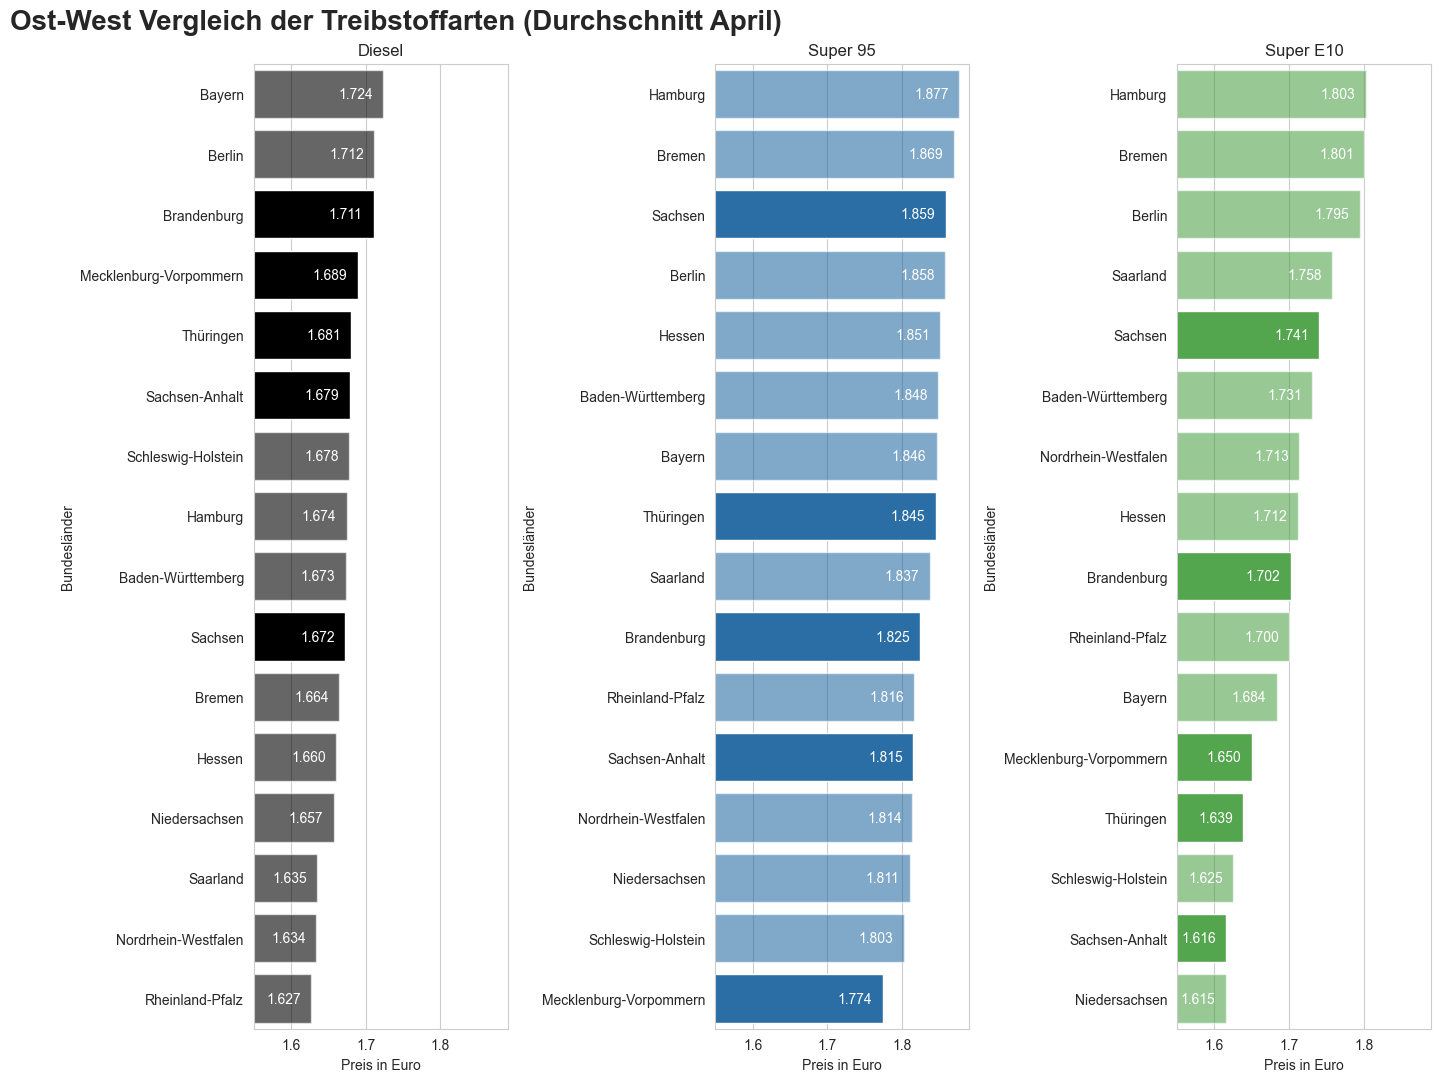

In [10]:
# mean per station
month_means = april_2023.groupby('station_uuid').mean().reset_index()

# adding postcode to stations
month_means = month_means.merge(stations[['station_uuid', 'post_code']], on='station_uuid')

# mean by postcode
month_postcode_means = month_means.astype({'post_code': 'int'}).groupby('post_code').mean().reset_index()

# merging postcode to Bundesländer + calculating mean of it 
plz_bundesland = pd.read_csv('plz-buland-kreis.csv', delimiter= '\;')
plz_bundesland = plz_bundesland[['plz', 'bundesland']].drop_duplicates().rename(columns={'plz': 'post_code'})
bundland_preise = month_postcode_means.merge(plz_bundesland, on='post_code').groupby('bundesland').mean().reset_index()

# creating a figure to have three barplots next to each other + title
fig, ax = plt.subplots(1, 3, figsize=(width, 11))
sns.set_style('whitegrid')
title = fig.suptitle('Ost-West Vergleich der Treibstoffarten (Durchschnitt April)', fontsize= title_fontsize, fontweight= 'bold')
title.set_x(0.27)

# for iterating 
fuelTypes = ['diesel', 'e5', 'e10'] 

# color codes for fuel types 
colors = ['#000000', '#1670B9', '#46b340'] 

# adding transperancy column 
neue_laender = ["Brandenburg", "Mecklenburg-Vorpommern", "Sachsen", "Sachsen-Anhalt", "Thüringen"]
bundland_preise['alpha'] = bundland_preise['bundesland'].apply(lambda x: 1 if x in neue_laender else 0.6)

# plotting a barplot per fuelType 
for i, fuelType in enumerate(fuelTypes):
    bundland_preise_sorted = bundland_preise.sort_values(by=fuelType, ascending=False)
    sns.barplot(data=bundland_preise_sorted, y='bundesland', x=fuelType, color=colors[i], ax=ax[i],
                order=bundland_preise_sorted['bundesland'])
    
    # correct the x-ax
    ax[i].set_xlim(1.55, 1.89)

    # modifying alpha based on alpha column and text in the bars with annotate 
    for bar, alpha in zip(ax[i].patches, bundland_preise_sorted['alpha']):
        bar.set_alpha(alpha)
        ax[i].annotate("%.3f" % bar.get_width(), xy=(bar.get_width(), bar.get_y()+bar.get_height()/2),
                       xytext=(-45, 0), textcoords='offset pixels', ha="left", va="center", color='white')
        
# array for wanted fuel types 
fuelTypes_label = ['Diesel', 'Super 95', 'Super E10']

# form changes
for i, fuelType_label in enumerate(fuelTypes_label):
    ax[i].set(title=fuelType_label, ylabel= 'Bundesländer', xlabel= 'Preis in Euro')

# plotting
plt.tight_layout()    
plt.show()

An den Plots erkennt man, dass Diesel generell günstiger ist als Super E10, was wiederum günstiger ist als Super 95. Die Rangfolge der Bundesländer sind bei Super E10 und Super E5 fast identisch. Die dunkleren Balken (schwarz, dunkel blau, dunkel grün) markieren die neuen Bundesländer. Wir hatten die Vermutung, dass die Preise in den neuen Länder geringer sein könnten, wie es öfter der Falls ist
bspw. im Falle von Grundstücken. Bei Diesel lässt sich alledings keinen Zusammenhang zwischen Ost-Ländern und Preis feststellen, da verteilt zwischen den anderen Bundesländern auftreten. Super 95 und Super E10 sind sogar eher teuerer in den neuen Ländern. Dabei ist auffällig, dass vier von fünf neuen Ländern direkt aufeinander folgen, was allerdings auch zufällig sein könnte, da sich Kraftstoffpreise häufig nur um ein paar Cent unterscheiden.

## Preisentwicklung der Kraftstoffe

Im Folgenden wollen wir die Preisentwicklung der Treibstoffarten (Diesel, Super 95 und Super E10) aufzeigen. Dabei gehen wir gesondert auf die Enwicklung der Preise unter Einfluss des Ukrainekiegs ein, so dass wir den Zeitabschnitt ab 2021 vergrößert als Nebenvisualisierung darstellen.

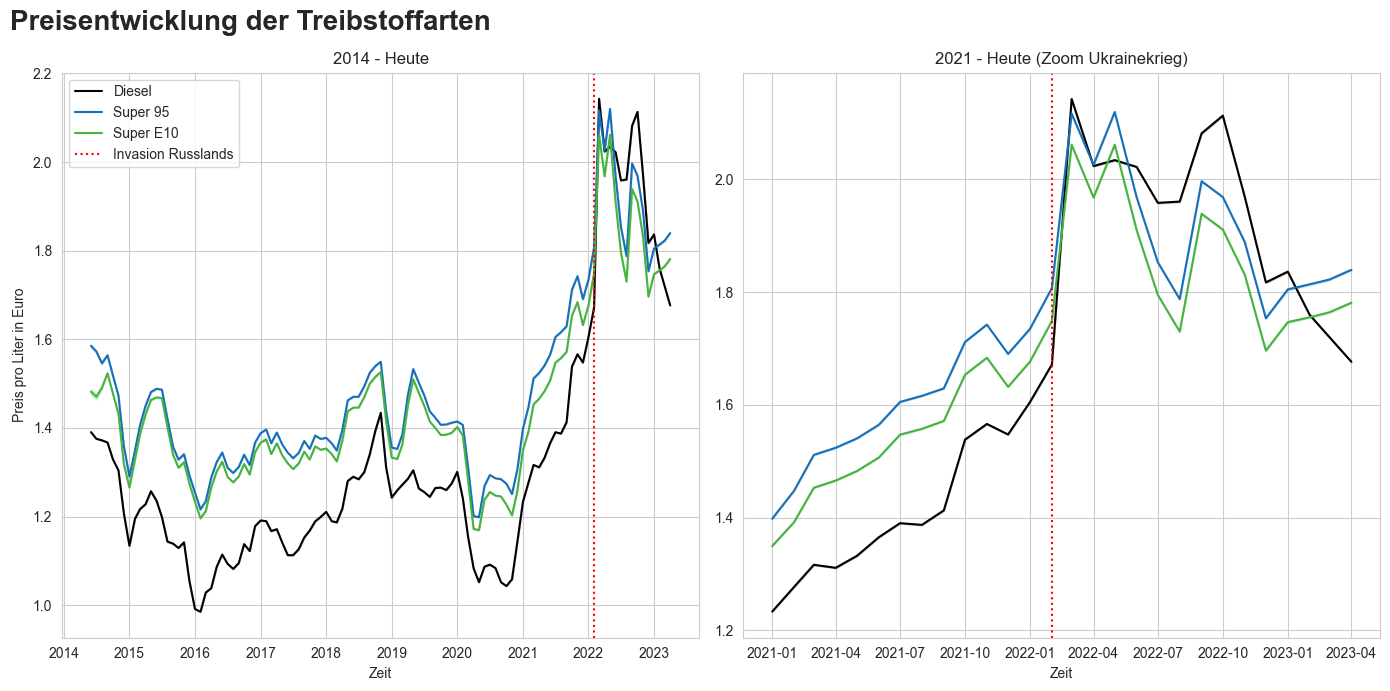

In [7]:
# creating df with wanted vars
preisentwicklung = timeseries[['date', 'diesel', 'e10', 'e5']]

# creating figure
fig, ax = plt.subplots(1,2, figsize=(width,7))
sns.set_style('whitegrid')

# style an form changes 
title = fig.suptitle('Preisentwicklung der Treibstoffarten', fontsize= title_fontsize, fontweight= 'bold')
title.set_x(0.18)

# creating line plots 
for fuelType, label, color in zip(fuelTypes,fuelTypes_label, colors):
    sns.lineplot(data=preisentwicklung, x='date', y=fuelType, label=label,ax= ax[0], color= color )
    sns.lineplot(data=preisentwicklung[preisentwicklung.date >= '2021-01-01'], 
                 x= 'date', y= fuelType, ax= ax[1], color= color )
    
line_label = 'Invasion Russlands'    
line_date = datetime.strptime('2022 02', '%Y %m')
ax[0].axvline(x=line_date, color='red', linestyle='dotted', label= line_label)
ax[1].axvline(x=line_date, color='red', linestyle='dotted')

# Add legend
ax[0].legend()

# style and form changes after plotting 
ax[0].set(title= '2014 - Heute', xlabel='Zeit', ylabel='Preis pro Liter in Euro')
ax[1].set(title= '2021 - Heute (Zoom Ukrainekrieg)', xlabel='Zeit', ylabel='')

# plotting
plt.tight_layout()
plt.show()

Die zwei oberen Grafiken veranschaulicht die Spritpreisentwicklungen der 3 Primärkraftstoffe Diesel, Super 95 und Super E10. Die x-Achse beschreibt die Zeit in Jahren, während die y-Achse Aufschluss auf den Preis pro Liter in Euro gibt. Der Grafik kann entnommen werden, dass bis auf ein paar Ausnahmen Diesel der günstigere und Super 95 der teuerste Kraftstoff ist.

Die granularere Darstellung der Achsen im rechten Plot gleicht einem Zoom-Effekt und stellt somit den Zeitraum der Jahre 2021 bis heute dar. Dieser Zeitraum ist wegen des starken Preisanstieges, ausgelöst durch den Angriffskrieg Russlands auf die Ukraine und der Vielzahl an Preiseinflüssen hervorzuheben. 
Anfang des Jahres 2022 ist ein Anstieg der Spritpreise basierend auf dem Anstieg des Ölpreises auf Basis guter Konjunkturaussichten, zu erkennen. Der auf den 24. Februar 2022 folgende starke Spritpreisanstieg lässt sich wie folgt erklären. Die Angst vor Lieferengpässen im Energiebereich auf Grund der damals drohenden Sanktionen führte zur Preisexplosionen bei Öl und Gas, schließlich waren damals die Ausmaße nicht bekannt. Die Angst vor Energieknappheit und die damit verbundene erhöhte Zahlungsbereitschaft der Abnehmer führte bei Investoren zu Spekulationen auf steigende Preise, welche natürlich selbst in gewissen Maßen zur Preissteigerung beitrugen.